<a href="https://colab.research.google.com/github/nowei/adversarial-dl/blob/master/projected_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# ResNet

*Author: Pytorch Team*

**Deep residual networks pre-trained on ImageNet**

<img src="https://pytorch.org/assets/images/resnet.png" alt="alt" width="50%"/>

In [3]:
import torch
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet34', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet152', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.4.2.zip" to /root/.cache/torch/hub/v0.4.2.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(3 x H x W)`, where `H` and `W` are expected to be at least `224`.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

Here's a sample execution.

In [4]:
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
with open('imagenet1000_clsidx_to_labels.txt', 'r') as f:
    classes = eval(f.read())

--2019-11-23 03:54:54--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.01s   

2019-11-23 03:54:54 (2.43 MB/s) - ‘imagenet1000_clsidx_to_labels.txt’ saved [30564/30564]



In [0]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://pbs.twimg.com/media/DzIyOyEWwAAOxWv.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

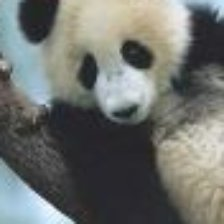

In [6]:
from IPython.display import Image as imshow
imshow(filename)


In [19]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import torch
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
data = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

def fgsm_attack(image, epsilon, data_graph):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    print('changed', torch.sum(epsilon*sign_data_grad))
    return perturbed_image

epsilon = 20/255
target = torch.zeros(1,dtype=torch.long)
target[0] = 1
device = 'cuda'
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    data = data.to(device)
    model.to(device)
    # Send the data and label to the device
    target = target.to(device)

    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True
    
    # Forward pass the data through the model
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    print(classes[init_pred.item()], torch.nn.functional.softmax(output[0], dim=0).max())
    # Calculate the loss
    loss = F.nll_loss(output, target)
    
    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = data.grad.data

    # Call FGSM Attack
    perturbed_data = fgsm_attack(data, epsilon, data_grad)

    # Re-classify the perturbed image
    output = model(perturbed_data)
    print('perturbedddddd')
# with torch.no_grad():
    # output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probs = torch.nn.functional.softmax(output[0], dim=0)

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca tensor(0.8202, device='cuda:0', grad_fn=<MaxBackward1>)
changed tensor(29.8039, device='cuda:0')
perturbedddddd


In [0]:
def proj_grad_desc(x, y, model, step_size, epsilon, steps=50, target=None):
    adversary = x.clone().detach().requires_grad_(True).to(x.device)
    max_diff = x + epsilon
    min_diff = x - epsilon
    for i in range(steps):
        curr = adversary.clone().detach().requires_grad_(True).to(adversary.device)
        output = model(curr)
        loss = F.nll_loss(output, target if target else y)
        loss.backward()
        with torch.no_grad():
            curr_grad = curr.grad * step_size 
            if target:
                adversary -= curr_grad
            else:
                adversary += curr_grad
        adversary = torch.max(torch.min(adversary, max_diff), min_diff)
    return adversary.detach()

In [0]:
trans = transforms.ToPILImage()

In [0]:
preprocess_2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
preprocess_3 = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                   
])

In [26]:
label = torch.tensor([388]).to(data.device)
print(classes[label.item()])
target = torch.tensor([368]).to(data.device)
# target = None
if target:
    print(classes[target.item()])
adv = proj_grad_desc(data, label, model, 0.01, 0.999 * 1/255, steps=50, target=target)
# curr = preprocess_3(preprocess_2(input_image) + (data - adv).to('cpu'))
# print(curr)
# print(classes[model(curr.to(data.device)).argmax().item()])
# trans(curr[0].to('cpu')).save('nani.jpg')
trans(input_tensor.to('cpu')).save('nanie.jpg')
result = model(adv)
probs = torch.nn.functional.softmax(result[0], dim=0)
print(classes[probs.argmax().item()], probs.max())
trans(adv.to('cpu')[0]).save('pgd_doggo.jpg')

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
gibbon, Hylobates lar
gibbon, Hylobates lar tensor(0.8041, device='cuda:0', grad_fn=<MaxBackward1>)


In [122]:
print(classes[probs.argmax().item()])

poncho


In [0]:
local = trans(perturbed_data.to('cpu')[0])
trans(data.to('cpu')[0]).save('orig_doggo.jpg')
local.save('doggo.jpg')

### Model Description

Resnet models were proposed in "Deep Residual Learning for Image Recognition".
Here we have the 5 versions of resnet models, which contains 5, 34, 50, 101, 152 layers respectively.
Detailed model architectures can be found in Table 1.
Their 1-crop error rates on imagenet dataset with pretrained models are listed below.

| Model structure | Top-1 error | Top-5 error |
| --------------- | ----------- | ----------- |
|  resnet18       | 30.24       | 10.92       |
|  resnet34       | 26.70       | 8.58        |
|  resnet50       | 23.85       | 7.13        |
|  resnet101      | 22.63       | 6.44        |
|  resnet152      | 21.69       | 5.94        |

### References

 - [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)